<a href="https://colab.research.google.com/github/AschHarwood/social_unrest/blob/main/regions_neural_prophet_11_12_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Imports

In [4]:
!pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-y865ku0q
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-y865ku0q
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 155 kB 2.3 MB/s 
  Created wheel for neuralprophet: filename=neuralprophet-0.2.9-py3-none-any.whl size=66491 sha256=cdef1d34e4476ac77de756f47651845f14e30b8b38464836443f75a1f3d076fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-okz507i2/wheels/bc/d0/dd/f2b1133865669ed9b544f6f1ff9155aedf57c9dbfc72ce211e
Successfully built neuralprophet
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


In [14]:
# import wandb
# from wandb.keras import WandbCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pycaret.utils import enable_colab 
#enable_colab()
#%pip install tensorflow_hub
import tensorflow_hub as hub
import tensorflow as tf
# import us
import plotly.express as px
from neuralprophet import NeuralProphet
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

#Loading and Preprocessing Data

In [5]:
df = pd.read_parquet('/content/drive/MyDrive/social_unrest_data/regions_with_policy_11_4.parquet')

In [6]:
pd.set_option('display.max_columns', 500)

In [7]:
df.columns = df.columns.astype(str)

In [8]:
df.region = df.region.str.decode('utf-8')

In [9]:
df.head()

,date,region,cases_avg,cases_avg_per_100k,deaths_avg,deaths_avg_per_100k,cases,deaths,Mobility_score,info_tweets,info_tweets_T,info_tweets_RE,info_tweets_RT,info_tweets_local,info_tweets_verified,info_tweets_unverified,info_fact_reliable,info_fact_unreliable,info_fact_unknown,info_fact_unreliable_fraction,info_fact_shadow,info_fact_missing,info_fact_science,info_fact_msm,info_fact_satire,info_fact_clickbait,info_fact_political,info_fact_fake,info_fact_conspiracy,info_iri,info_iri_T,info_iri_RE,info_iri_RT,info_dyn_iri,info_dyn_iri_RE,info_dyn_iri_RT,reddit_comments_1,reddit_comments_2,reddit_sentiment,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Rate_filled,year,month,day,Governor Political Affiliation_Democrat,Governor Political Affiliation_Republican,Governor Political Affiliation_Unknown,State Senate Majority Political Affiliation_Democrat,State Senate Majority Political Affiliation_Other,State Senate Majority Political Affiliation_Republican,State Senate Majority Political Affiliation_Unknown,State House Majority Political Affiliation_Democrat,State House Majority Political Affiliation_Republican,State House Majority Political Affiliation_Unknown,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,Bar Closures_Closed,Bar Closures_New Service Limits,Bar Closures_Newly Closed,Bar Closures_Reopened,Bar Closures_unknown,Bar Closures*_Closed,Bar Closures*_New Service Limits,Bar Closures*_Open,Bar Closures*_Open for Outdoor Service Only,Bar Closures*_Open with Service Limits,Bar Closures*_Reopened,Bar Closures*_unknown,Emergency Declaration_No,Emergency Declaration_Yes,Emergency Declaration_unknown,Face Covering Requirement_-,Face Covering Requirement_Allows Local Officals to Require for General Public,Face Covering Requirement_Allows Local Officials to Require for General Public,Face Covering Requirement_Required for Certain Employees,Face Covering Requirement_Required for Certain Employees;\nAllows Local Officials to Require for General Public,Face Covering Requirement_Required for Certain Employees; Required for General Public,Face Covering Requirement_Required for General Public,Face Covering Requirement_Required for General Public (New),Face Covering Requirement_unknown,Large Gatherings Ban_>10 People Prohibited,Large Gatherings Ban_>10 Prohibited,Large Gatherings Ban_>25 Prohibited,Large Gatherings Ban_>50 Prohibited,Large Gatherings Ban_All Gatherings Prohibited,Large Gatherings Ban_Expanded Limit to 25 or Fewer,Large Gatherings Ban_Expanded Limit to Greater Than 25,Large Gatherings Ban_Expanded to New Lim

In [10]:
df.protest_binary_count.value_counts()

0     1611
1     1106
2      609
3      236
4       86
5       21
6        6
7        1
10       1
Name: protest_binary_count, dtype: int64

In [11]:
df.set_index('date', inplace=True)

In [12]:
df = df['2020-01-13':]

In [ ]:
df.info(max_cols=500)

In [17]:
df

,region,cases_avg,cases_avg_per_100k,deaths_avg,deaths_avg_per_100k,cases,deaths,Mobility_score,info_tweets,info_tweets_T,info_tweets_RE,info_tweets_RT,info_tweets_local,info_tweets_verified,info_tweets_unverified,info_fact_reliable,info_fact_unreliable,info_fact_unknown,info_fact_unreliable_fraction,info_fact_shadow,info_fact_missing,info_fact_science,info_fact_msm,info_fact_satire,info_fact_clickbait,info_fact_political,info_fact_fake,info_fact_conspiracy,info_iri,info_iri_T,info_iri_RE,info_iri_RT,info_dyn_iri,info_dyn_iri_RE,info_dyn_iri_RT,reddit_comments_1,reddit_comments_2,reddit_sentiment,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Rate_filled,year,month,day,Governor Political Affiliation_Democrat,Governor Political Affiliation_Republican,Governor Political Affiliation_Unknown,State Senate Majority Political Affiliation_Democrat,State Senate Majority Political Affiliation_Other,State Senate Majority Political Affiliation_Republican,State Senate Majority Political Affiliation_Unknown,State House Majority Political Affiliation_Democrat,State House Majority Political Affiliation_Republican,State House Majority Political Affiliation_Unknown,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,Bar Closures_Closed,Bar Closures_New Service Limits,Bar Closures_Newly Closed,Bar Closures_Reopened,Bar Closures_unknown,Bar Closures*_Closed,Bar Closures*_New Service Limits,Bar Closures*_Open,Bar Closures*_Open for Outdoor Service Only,Bar Closures*_Open with Service Limits,Bar Closures*_Reopened,Bar Closures*_unknown,Emergency Declaration_No,Emergency Declaration_Yes,Emergency Declaration_unknown,Face Covering Requirement_-,Face Covering Requirement_Allows Local Officals to Require for General Public,Face Covering Requirement_Allows Local Officials to Require for General Public,Face Covering Requirement_Required for Certain Employees,Face Covering Requirement_Required for Certain Employees;\nAllows Local Officials to Require for General Public,Face Covering Requirement_Required for Certain Employees; Required for General Public,Face Covering Requirement_Required for General Public,Face Covering Requirement_Required for General Public (New),Face Covering Requirement_unknown,Large Gatherings Ban_>10 People Prohibited,Large Gatherings Ban_>10 Prohibited,Large Gatherings Ban_>25 Prohibited,Large Gatherings Ban_>50 Prohibited,Large Gatherings Ban_All Gatherings Prohibited,Large Gatherings Ban_Expanded Limit to 25 or Fewer,Large Gatherings Ban_Expanded Limit to Greater Than 25,Large Gatherings Ban_Expanded to New Limit Ab

# Normalized Regressors

In [41]:
features = []
targets = []
for region in df.region.unique():
  region_df = df[df.region==region]
  region_targets = region_df[['protest_binary_count', 'target_bins', 'region']]
  region_features = region_df.drop(['protest_binary_count', 'target_bins', 'region'], axis=1)
  scaler = RobustScaler()
  region_features = scaler.fit_transform(region_features)
  pca = PCA(n_components=.9999)
  region_features = pca.fit_transform(region_features)
  region_features = pd.DataFrame(region_features)
  region_features.reset_index(inplace=True, drop=True)
  region_targets.reset_index(inplace=True)
  region_df = pd.concat([region_targets, region_features], axis=1)
  features.append(region_df)
  targets.append(region_targets)


In [42]:
features[0]

,date,protest_binary_count,target_bins,region,0,1
0,2020-01-13,0,0,great_lakes,-1856.918703,446.561198
1,2020-01-14,0,0,great_lakes,-1856.918703,446.561122
2,2020-01-15,0,0,great_lakes,-1856.918704,446.561152
3,2020-01-16,0,0,great_lakes,-1856.918704,446.560976
4,2020-01-17,0,0,great_lakes,-1856.918703,446.560378
...,...,...,...,...,...,...
454,2021-04-11,1,1,great_lakes,12372.984898,-29.477453
455,2021-04-12,0,0,great_lakes,17737.898892,0.680143
456,2021-04-13,1,1,great_lakes,18914.879670,7.274612
457,2021-04-14,1,1,great_lakes,15892.928336,-9.688040


In [49]:
df_x_y = features[0].drop(['target_bins', 'region'], axis=1)
df_x_y.rename(columns={'date': 'ds', 'protest_binary_count': 'y', 0: 'feature_1', 1: 'feature_2'}, inplace=True)

In [50]:
lagged_regressors = list(df_x_y[['feature_1', 'feature_2']].columns)

In [51]:
lagged_regressors

['feature_1', 'feature_2']

In [52]:
m = NeuralProphet(n_forecasts=3, n_lags=10, num_hidden_layers=2, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)

In [55]:
m.add_lagged_regressor(lagged_regressors)

In [54]:
df_x_y

,ds,y,feature_1,feature_2
0,2020-01-13,0,-1856.918703,446.561198
1,2020-01-14,0,-1856.918703,446.561122
2,2020-01-15,0,-1856.918704,446.561152
3,2020-01-16,0,-1856.918704,446.560976
4,2020-01-17,0,-1856.918703,446.560378
...,...,...,...,...
454,2021-04-11,1,12372.984898,-29.477453
455,2021-04-12,0,17737.898892,0.680143
456,2021-04-13,1,18914.879670,7.274612
457,2021-04-14,1,15892.928336,-9.688040


In [56]:
metrics = m.fit(df_x_y, freq='D')

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 219


  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.78E-03, min: 1.16E+01


  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.35E+00, min: 1.13E+00


  0%|          | 0/232 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.78E-03, min: 1.23E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.96E-02
Epoch[219/219]: 100%|██████████| 219/219 [00:27<00:00,  7.87it/s, SmoothL1Loss=0.0195, MAE=0.434, RMSE=0.589, RegLoss=0]


In [57]:
forecast = m.predict(df_x_y)

In [58]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,ar1,ar2,ar3,lagged_regressor_feature_11,lagged_regressor_feature_12,lagged_regressor_feature_13,lagged_regressor_feature_21,lagged_regressor_feature_22,lagged_regressor_feature_23,trend
0,2020-01-13,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2020-01-14,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2020-01-15,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2020-01-16,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,2020-01-17,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,2021-04-11,1.0,0.795866,-0.204134,0.515408,-0.484592,0.302732,-0.697268,-0.55222,-0.563963,-0.745442,0.32224,-0.125873,-0.0765874,-0.362275,-0.182877,-0.26336,1.38812
455,2021-04-12,0.0,-0.0263592,-0.0263592,0.262035,0.262035,0.52411,0.52411,-1.25294,-0.786294,-0.673492,0.226939,-0.145548,0.0603466,-0.38594,-0.19171,-0.248331,1.38559
456,2021-04-13,1.0,1.04776,0.0477607,0.270595,-0.729405,0.542985,-0.457015,0.0364054,-0.801974,-0.657958,0.0191166,-0.123339,0.0755852,-0.390812,-0.187142,-0.257693,1.38305
457,2021-04-14,1.0,-0.181331,-1.18133,1.06595,0.0659547,0.19855,-0.80145,-0.863952,0.111636,-0.973202,-0.0866511,-0.238737,0.0518206,-0.611244,-0.18746,-0.260584,1.38052


In [59]:
forecast = forecast.dropna()

In [60]:
forecast.set_index('ds', inplace=True)

In [61]:
forecast.reset_index(inplace=True)

In [62]:
forecast.loc[:, 'yhat1':] = forecast.loc[:, 'yhat1':].astype(float)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [81]:
rolling_sum_10 = forecast.set_index('ds').rolling(10).sum()

In [74]:
 week_f = forecast.groupby(pd.Grouper(key='ds',freq='W')).rolling().sum()

ValueError: ignored

In [69]:
week_f.reset_index(inplace=True)

In [70]:
week_yhat_1 = week_f.loc[:, 'ds': 'residual1']

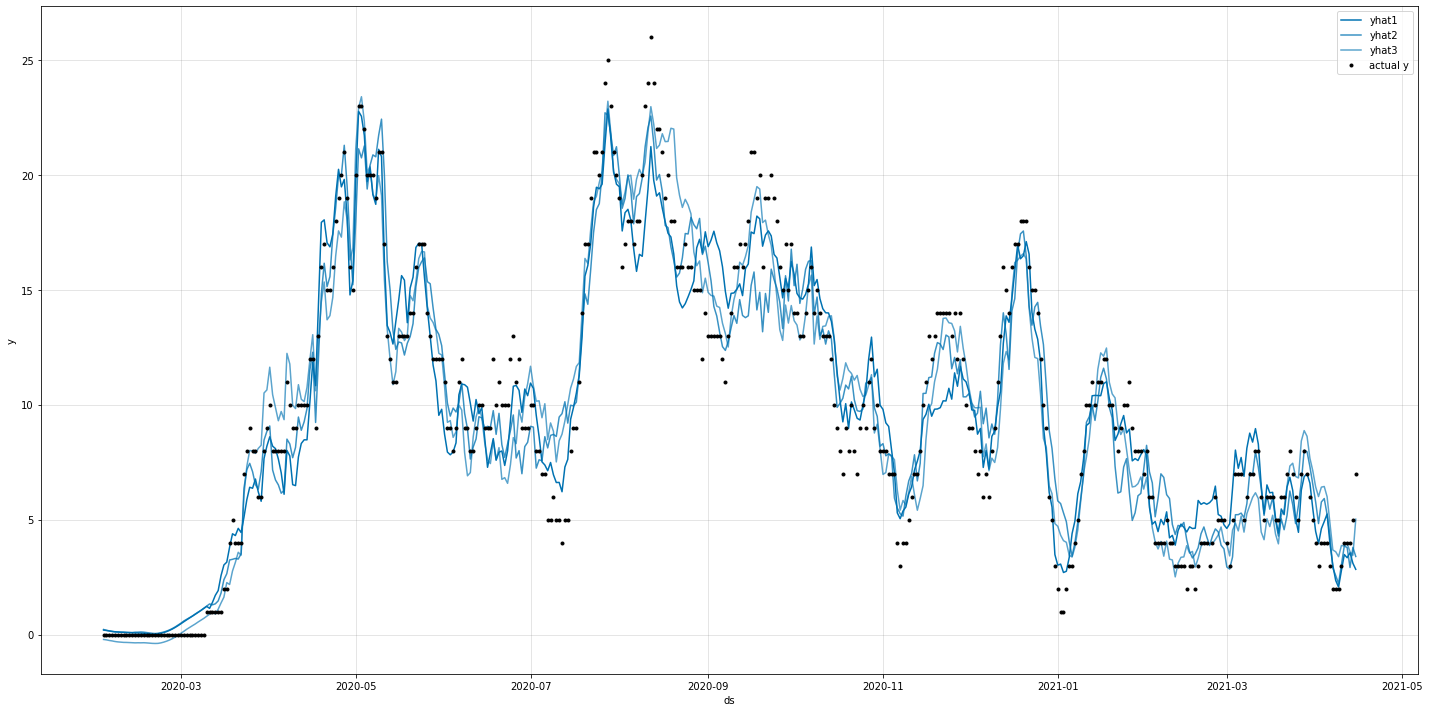

In [83]:
fig1 = m.plot(rolling_sum_10.reset_index(), figsize=(20,10))


In [84]:
rolling_sum_10.reset_index(inplace=True)

In [86]:
rolling_sum_10 = rolling_sum_10[['ds', 'y', 'yhat1', 'yhat2', 'yhat3']]

In [89]:
rolling_sum_10.dropna(inplace=True)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [91]:
rolling_sum_10

,ds,y,yhat1,yhat2,yhat3
9,2020-02-03,0.0,0.199286,0.225410,-0.208753
10,2020-02-04,0.0,0.183120,0.189296,-0.226018
11,2020-02-05,0.0,0.159903,0.166219,-0.252475
12,2020-02-06,0.0,0.144092,0.137431,-0.272206
13,2020-02-07,0.0,0.126925,0.120427,-0.297503
...,...,...,...,...,...
442,2021-04-11,4.0,3.483855,3.856847,3.857543
443,2021-04-12,4.0,3.345995,3.785815,3.955855
444,2021-04-13,4.0,3.563465,2.920465,3.606588
445,2021-04-14,5.0,3.104537,3.792070,3.453529


In [106]:
fig = px.scatter(rolling_sum_10, x='ds', y='y')
fig.add_scatter(x=rolling_sum_10['ds'], y=rolling_sum_10['yhat1'], mode='lines')
fig.add_scatter(x=rolling_sum_10['ds'], y=rolling_sum_10['yhat2'], mode='lines')
fig.add_scatter(x=rolling_sum_10['ds'], y=rolling_sum_10['yhat3'], mode='lines')

fig.show()

In [ ]:
m.add_lagged_regressor()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
